# Homework 3 - Interactive Viz

In [2]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import folium
import re
import sys

## European unemployment rates

_Go to the [eurostat](http://ec.europa.eu/eurostat/data/database) website and try to find a dataset that includes the european unemployment rates at a recent date._

   _Use this data to build a _[Choropleth map](https://en.wikipedia.org/wiki/Choropleth_map) _which shows the unemployment rate in Europe at a country level. Think about [the colors you use](https://carto.com/academy/courses/intermediate-design/choose-colors-1/),how you decided to [split the intervals into data classes](http://gisgeography.com/choropleth-maps-data-classification/) or which interactions you could add in order to make the visualization intuitive and expressive. Compare Switzerland's unemployment rate to that of the rest of Europe._

On the eurostat website, we found our dataset under 'Database by themes/Population and social conditions/Labour Market(labour)/Employment and unemployment/LFS main indicators/Unemployment - LFS adjusted series/Unemployment by sex and age - annual average'. It provides the unemployment rates up to 2016 for all european countries. On the contrary of its name, both sex and all ages are mixed.

In [2]:
CSV_PATH = 'data/question1/une_rt_a_1_Data.csv'

europe_df = pd.read_csv(CSV_PATH) 

europe_df = europe_df.loc[europe_df['TIME'] == 2016]
europe_df = europe_df.loc[europe_df['UNIT'] == 'Percentage of active population']
europe_df = europe_df.drop(['TIME','AGE', 'SEX','UNIT','Flag and Footnotes'], axis = 1)
europe_df = europe_df[6:]
europe_df = europe_df[:30]
# Clean Germany's name
europe_df['GEO'] = europe_df['GEO'].str.replace(r"\(.*\)","")
europe_df['Value'] = europe_df['Value'].astype(float)
europe_df = europe_df[~(europe_df['GEO'] == 'Cyprus')]
europe_df = europe_df[~(europe_df['GEO'] == 'Malta')]

In [3]:
for line in europe_df['GEO']:
    if line == 'Germany ':
        line = 'Germany'
europe_df.head()

,GEO,Value
1073,Belgium,7.8
1076,Bulgaria,7.6
1079,Czech Republic,4.0
1082,Denmark,6.2
1085,Germany,4.1


In [4]:
state_topo_path = r'topojson/europe.topojson.json'
topo_json_data = json.load(open(state_topo_path))

In [5]:
length = europe_df.shape[0]
for i in range(0,51):
    present = 0
    for index, row in europe_df.iterrows():
        if row['GEO'] == topo_json_data['objects']['europe']['geometries'][i]['properties']['NAME']:
            present = 1
            presence_row = row
    if present == 0:
        if topo_json_data['objects']['europe']['geometries'][i]['properties']['NAME'] == 'Switzerland':
            europe_df.loc[-1] = [topo_json_data['objects']['europe']['geometries'][i]['properties']['NAME'],3.5]
        else:
            europe_df.loc[-1] = [topo_json_data['objects']['europe']['geometries'][i]['properties']['NAME'],-1]  # adding a row
        europe_df.index = europe_df.index + 1  # shifting index
        europe_df = europe_df.sort_index()
        #europe_df = europe_df.append({'GEO'}: topo_json_data['objects']['europe']['geometries'][i]['properties']['NAME'], {'Value'}: 'NaN', ignore_index=True)

europe_df = europe_df[~(europe_df['GEO'] == 'Germany')]

In [18]:
def unemployment_color(state):
    if state == 'Germany':
        value = 4.1
    else:
        value = float(europe_df.loc[europe_df['GEO'] == state, 'Value'].values)
        
    if value < 0:
        return '#000000'
    elif value < 4:
        return '#FAF5D0'
    elif value < 6:
        return '#FAED88'
    elif value < 8:
        return '#FCDF02'
    elif value < 10:
        return '#FABB82'
    elif value < 12:
        return '#ff6600'  
    else:
        return '#ff0000'

    
results_map = folium.Map([54,17], tiles='cartodbpositron', zoom_start=4)
folium.TopoJson(
    data = topo_json_data,
    object_path = 'objects.europe',
    style_function=lambda feature: {
        'fillColor': unemployment_color(feature['properties']['NAME']),
        'color' : 'black',
        'weight' : 2,
        'opacity': 0.1}).add_to(results_map)

results_map

On the graph above, one can observe the unemployment rate for most european countries. For countries which are not part of the EU, nor Switzerland will appear in grey. For all the others, a linear scale from white to red is created. The countries in yellow present a rate lower than 4%, light yellow with 6%, light orange with 8% , orange with 10% and red for anything above.

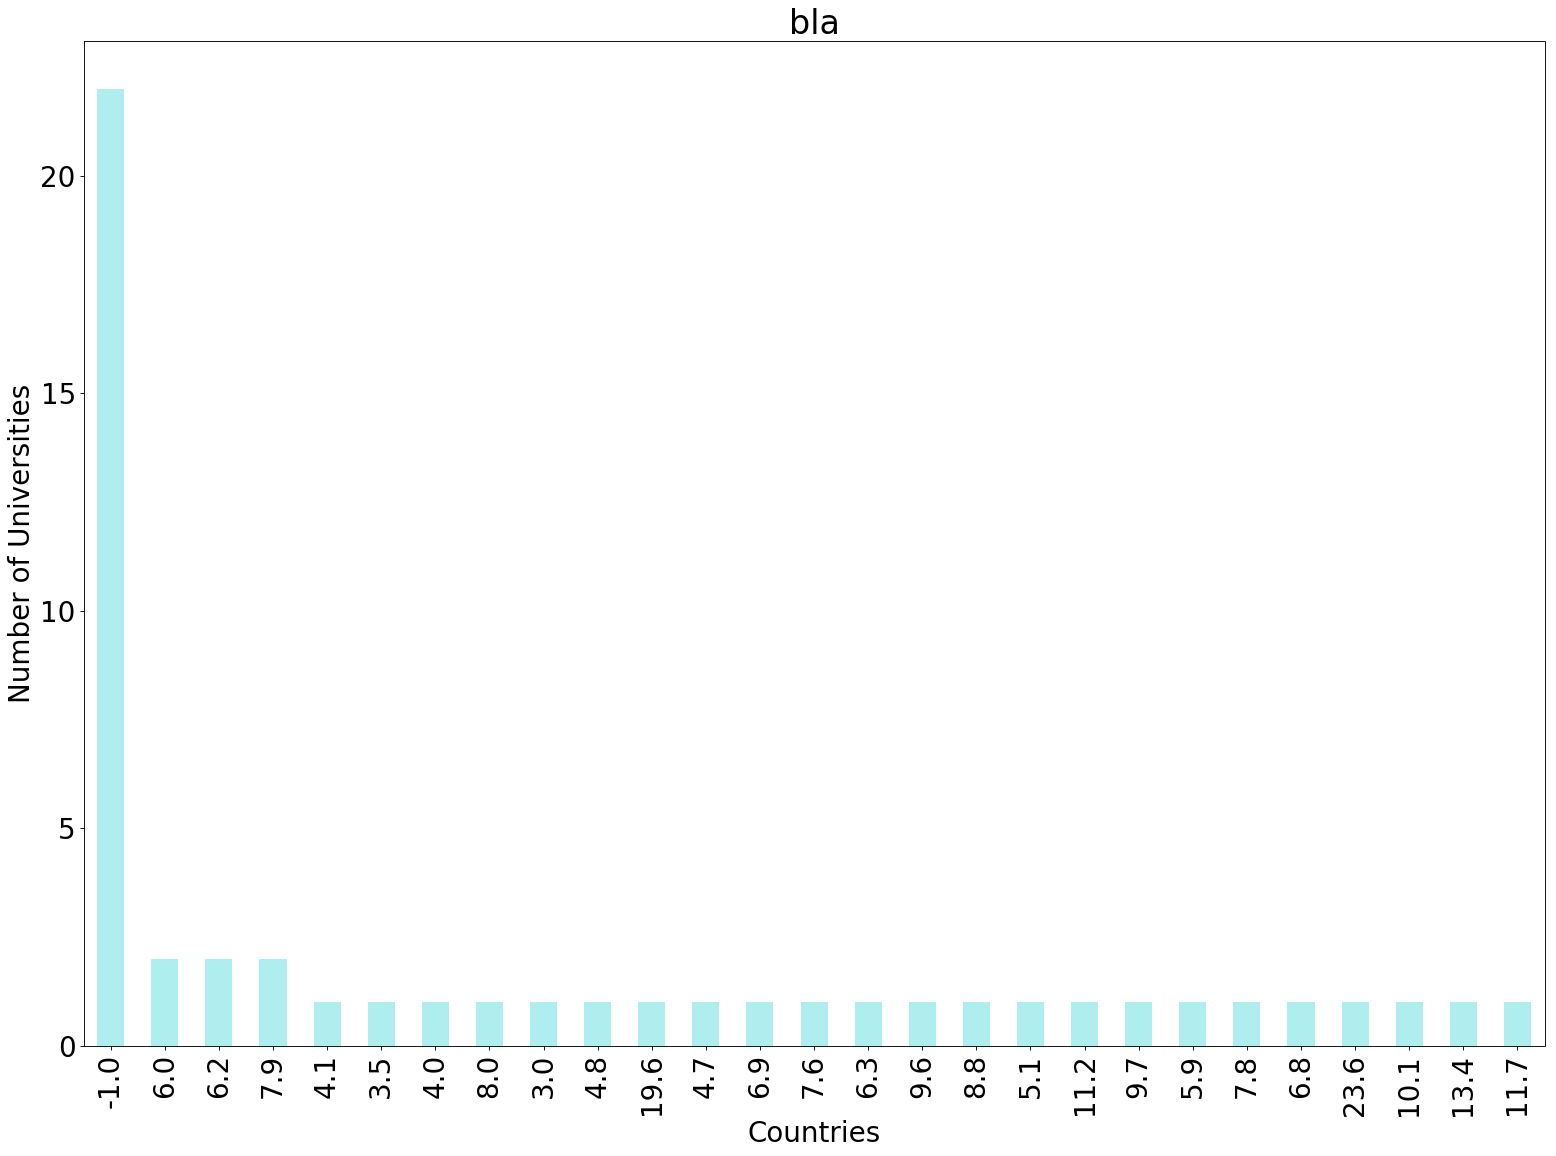

In [30]:
fig = plt.figure(figsize=(20, 15), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 25})

embarkedPlot = europe_df['Value'].value_counts().plot(kind='bar', color='paleturquoise')
embarkedPlot.set_xlabel("Countries")
embarkedPlot.set_ylabel("Number of Universities")
plt.title('bla')

fig.tight_layout()
plt.show()

## Swiss Cantons unemployement

_Go to the [amstat](https://www.amstat.ch) website to find a dataset that includes the unemployment rates in Switzerland at a recent date._

   > *HINT* Go to the `details` tab to find the raw data you need. If you do not speak French, German or Italian, think of using free translation services to navigate your way through. 

  _ Use this data to build another Choropleth map, this time showing the unemployment rate at the level of swiss cantons. Again, try to make the map as expressive as possible, and comment on the trends you observe._

  _ The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization._

  _ Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one. How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data._

## Foreign workers in Switzerland


_Use the [amstat](https://www.amstat.ch) website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between *Swiss* and *foreign* workers._

  _The Economic Secretary (SECO) releases [a monthly report](https://www.seco.admin.ch/seco/fr/home/Arbeit/Arbeitslosenversicherung/arbeitslosenzahlen.html) on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for *foreign* (`5.1%`) and *Swiss* (`2.2%`) workers. _

  _ Show the difference in unemployment rates between the two categories in each canton on a Choropleth map (*hint* The easy way is to show two separate maps, but can you think of something better ?). Where are the differences most visible ? Why do you think that is ?_

  _ Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data._

In [20]:
TXT_PATH = 'data/question_2_3/swiss_unemployment.txt'

switzerland_df = pd.read_table(TXT_PATH, ',') 

# Cleaning
switzerland_df = switzerland_df.drop('Mois', 1)
switzerland_df = switzerland_df.drop(switzerland_df.index[[0]])
switzerland_df = switzerland_df.drop(switzerland_df.index[[len(switzerland_df) - 1]])
switzerland_df = switzerland_df.rename(index=str, columns={ "Total" : "Taux de chômage", "Total.1" : "Chômeurs inscrits"});
cols = [col for col in switzerland_df.columns if col  in ['Canton', 'Nationalité', 'Taux de chômage', 'Chômeurs inscrits']]
switzerland_df = switzerland_df[cols]

switzerland_df['Chômeurs inscrits'] = switzerland_df['Chômeurs inscrits'].str.replace("'", "")

In [34]:
switzerland_df.head()

,Canton,Nationalité,Taux de chômage,Chômeurs inscrits
1,Zurich,Etrangers,5.3,120430
2,Zurich,Suisses,2.4,143239
3,Berne,Etrangers,5.7,50777
4,Berne,Suisses,1.8,83379
5,Lucerne,Etrangers,4,16379


In [27]:
previous_canton = 'None'
foreign_unempl = 0
swiss_df = pd.DataFrame(columns=['Canton','ID','Difference Foreigners-Locals'])


for index, row in switzerland_df.iterrows():
    if row['Canton'] == previous_canton:
        swiss_df.loc[-1] = [row['Canton'],'NaN',float(foreign_unempl) - float(row['Taux de chômage'])]
        swiss_df.index = swiss_df.index + 1  # shifting index
        swiss_df = swiss_df.sort_index()
    else:
        previous_canton = row['Canton']
        foreign_unempl = row['Taux de chômage']

In [35]:
ID_list = ['JU','GE','NE','VS','VD','TI','TG','AG','GR','SG','AI','AR','SH',\\
           'BL','BS','SO','FR','ZG','GL','NW','OW','SZ','UR','LU','BE','ZH']
swiss_df['ID'] = ID_list  
swiss_df.head()

,Canton,ID,Difference Foreigners-Locals
0,Jura,JU,5.8
1,Genève,GE,1.1
2,Neuchâtel,NE,3.8
3,Valais,VS,4.4
4,Vaud,VD,2.6


In [36]:
canton_topo_path = r'topojson/ch-cantons.topojson.json'
topo_json_data = json.load(open(canton_topo_path))

In [38]:
def unemployment_color(canton):

    value = float(swiss_df.loc[swiss_df['ID'] == canton, 'Difference Foreigners-Locals'].values)
        
    if value < 0:
        return '#000000'
    elif value < 1:
        return '#FAF5D0'
    elif value < 2:
        return '#FAED88'
    elif value < 3:
        return '#FCDF02'
    elif value < 4:
        return '#FABB82'
    elif value < 5:
        return '#ff6600'  
    else:
        return '#ff0000'

    
results_map = folium.Map([54,17], tiles='cartodbpositron', zoom_start=4)
folium.TopoJson(
    data = topo_json_data,
    object_path = 'objects.cantons',
    style_function=lambda feature: {
        'fillColor': unemployment_color(feature['id']),
        'color' : 'black',
        'weight' : 2,
        'opacity': 0.1}).add_to(results_map)

results_map

In [10]:
topo_json_data['objects']['cantons']['geometries']

[{u'arcs': [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]],
  u'id': u'ZH',
  u'properties': {u'name': u'Z\xfcrich'},
  u'type': u'Polygon'},
 {u'arcs': [[[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], [23], [24]],
   [[25, 26]],
   [[27]],
   [[28, 29]]],
  u'id': u'BE',
  u'properties': {u'name': u'Bern/Berne'},
  u'type': u'MultiPolygon'},
 {u'arcs': [[-12, 30, 31, 32, 33, 34]],
  u'id': u'LU',
  u'properties': {u'name': u'Luzern'},
  u'type': u'Polygon'},
 {u'arcs': [[35, 36, 37, 38, -16, 39, 40, 41]],
  u'id': u'UR',
  u'properties': {u'name': u'Uri'},
  u'type': u'Polygon'},
 {u'arcs': [[42, -33, 43, -1, 44, 45, 46, -42]],
  u'id': u'SZ',
  u'properties': {u'name': u'Schwyz'},
  u'type': u'Polygon'},
 {u'arcs': [[[-13, -35, 47]], [[-15, 48, -40]]],
  u'id': u'OW',
  u'properties': {u'name': u'Obwalden'},
  u'type': u'MultiPolygon'},
 {u'arcs': [[-34, -43, -41, -49, -14, -48]],
  u'id': u'NW',
  u'properties': {u'name': u'Nidwalden'},
  u'type': u'Polygon'},
 {u'arcs': [[49, -36, -47, 50,

## Röstigraben

_ *BONUS*: using the map you have just built, and the geographical information contained in it, could you give a *rough estimate* of the difference in unemployment rates between the areas divided by the [Röstigraben](https://en.wikipedia.org/wiki/R%C3%B6stigraben)?_